# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": [],
    "x_transforms_target": [],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.04827418
Average power, source: 0.0030152015


Average magnitude, target: 0.073281765
Average power, target: 0.0064668506


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 2003.1025, train_label_loss: 4.0736, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3959.9094, train_label_loss: 3.3646, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4055.4561, train_label_loss: 3.2525, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4060.8519, train_label_loss: 2.6533, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4058.4278, train_label_loss: 2.6048, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3984.7549, train_label_loss: 2.4244, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4047.5417, train_label_loss: 2.0219, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4062.5871, train_label_loss: 1.8284, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4090.1008, train_label_loss: 1.7162, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4153.4168, train_label_loss: 1.8310, 


epoch: 1, source_val_acc_label: 0.8038, target_val_acc_label: 0.7425, source_val_label_loss: 1.4081, target_val_label_loss: 1.6598, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 503.7606, train_label_loss: 1.4149, 


epoch: 2, [batch: 5 / 45], examples_per_second: 4042.0463, train_label_loss: 1.0346, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4132.8297, train_label_loss: 0.9657, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4138.6525, train_label_loss: 1.0388, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4140.2058, train_label_loss: 1.0980, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4054.7121, train_label_loss: 0.9901, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4138.2137, train_label_loss: 0.8636, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4131.9012, train_label_loss: 0.9522, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4169.1595, train_label_loss: 0.8282, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4227.8766, train_label_loss: 0.7279, 


epoch: 2, source_val_acc_label: 0.8827, target_val_acc_label: 0.8175, source_val_label_loss: 0.6449, target_val_label_loss: 1.0003, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 491.6835, train_label_loss: 0.5501, 


epoch: 3, [batch: 5 / 45], examples_per_second: 4022.3011, train_label_loss: 0.7644, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4123.2852, train_label_loss: 0.7607, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4128.8797, train_label_loss: 0.6707, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4127.7738, train_label_loss: 0.5413, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4053.2509, train_label_loss: 0.7278, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4125.5517, train_label_loss: 0.6928, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4126.6507, train_label_loss: 0.3139, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4165.2434, train_label_loss: 0.5224, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4227.2620, train_label_loss: 0.5504, 


epoch: 3, source_val_acc_label: 0.9128, target_val_acc_label: 0.8380, source_val_label_loss: 0.5141, target_val_label_loss: 0.8881, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 495.9979, train_label_loss: 0.6576, 


epoch: 4, [batch: 5 / 45], examples_per_second: 4031.7694, train_label_loss: 0.4535, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4133.8904, train_label_loss: 0.7851, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4133.7102, train_label_loss: 0.5952, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4130.2940, train_label_loss: 0.4775, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4054.6313, train_label_loss: 0.5901, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4135.8360, train_label_loss: 0.5664, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4133.6271, train_label_loss: 0.5973, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4166.7687, train_label_loss: 0.3635, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4224.3898, train_label_loss: 0.3340, 


epoch: 4, source_val_acc_label: 0.9308, target_val_acc_label: 0.8483, source_val_label_loss: 0.4108, target_val_label_loss: 0.8423, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 492.8285, train_label_loss: 0.4886, 


epoch: 5, [batch: 5 / 45], examples_per_second: 4031.7843, train_label_loss: 0.3961, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4122.2705, train_label_loss: 0.3680, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4126.1914, train_label_loss: 0.4354, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4133.3811, train_label_loss: 0.5148, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4050.6878, train_label_loss: 0.3669, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4130.2142, train_label_loss: 0.3028, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4128.6239, train_label_loss: 0.3330, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4171.4241, train_label_loss: 0.6060, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4219.9744, train_label_loss: 0.3801, 


epoch: 5, source_val_acc_label: 0.9442, target_val_acc_label: 0.8605, source_val_label_loss: 0.3592, target_val_label_loss: 0.7668, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 494.2410, train_label_loss: 0.3670, 


epoch: 6, [batch: 5 / 45], examples_per_second: 4032.4194, train_label_loss: 0.2300, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4126.4196, train_label_loss: 0.4161, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4127.5157, train_label_loss: 0.2778, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4121.6520, train_label_loss: 0.3751, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4043.1883, train_label_loss: 0.5125, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4120.8592, train_label_loss: 0.4341, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4130.4645, train_label_loss: 0.4247, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4161.0705, train_label_loss: 0.2891, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4226.3986, train_label_loss: 0.3476, 


epoch: 6, source_val_acc_label: 0.9538, target_val_acc_label: 0.8722, source_val_label_loss: 0.3241, target_val_label_loss: 0.7237, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 495.2153, train_label_loss: 0.3339, 


epoch: 7, [batch: 5 / 45], examples_per_second: 4037.3654, train_label_loss: 0.1582, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4140.8284, train_label_loss: 0.3481, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4140.1244, train_label_loss: 0.2031, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4131.8323, train_label_loss: 0.3403, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4055.8908, train_label_loss: 0.2488, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4137.4491, train_label_loss: 0.3027, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4137.3078, train_label_loss: 0.2780, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4174.6549, train_label_loss: 0.3191, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4236.7843, train_label_loss: 0.3199, 


epoch: 7, source_val_acc_label: 0.9564, target_val_acc_label: 0.8741, source_val_label_loss: 0.2799, target_val_label_loss: 0.7066, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 493.9724, train_label_loss: 0.1380, 


epoch: 8, [batch: 5 / 45], examples_per_second: 4013.3055, train_label_loss: 0.3285, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4124.0555, train_label_loss: 0.3592, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4128.8572, train_label_loss: 0.3463, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4086.0871, train_label_loss: 0.3538, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4059.4225, train_label_loss: 0.4917, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4137.2780, train_label_loss: 0.2943, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4138.4822, train_label_loss: 0.3167, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4169.4796, train_label_loss: 0.3591, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4220.6963, train_label_loss: 0.1367, 


epoch: 8, source_val_acc_label: 0.9635, target_val_acc_label: 0.8744, source_val_label_loss: 0.2684, target_val_label_loss: 0.7214, 


New best


epoch: 9, [batch: 1 / 45], examples_per_second: 497.2872, train_label_loss: 0.2799, 


epoch: 9, [batch: 5 / 45], examples_per_second: 4020.8166, train_label_loss: 0.1995, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4142.3226, train_label_loss: 0.3611, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4136.3192, train_label_loss: 0.1933, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4138.6110, train_label_loss: 0.2277, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4061.4036, train_label_loss: 0.3546, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4140.6177, train_label_loss: 0.3015, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4142.6090, train_label_loss: 0.2995, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4170.5409, train_label_loss: 0.3761, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4229.4540, train_label_loss: 0.1965, 


epoch: 9, source_val_acc_label: 0.9571, target_val_acc_label: 0.8831, source_val_label_loss: 0.2635, target_val_label_loss: 0.6637, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 494.8375, train_label_loss: 0.2202, 


epoch: 10, [batch: 5 / 45], examples_per_second: 4035.0574, train_label_loss: 0.4681, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4130.5208, train_label_loss: 0.2100, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4115.5178, train_label_loss: 0.2092, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4125.8155, train_label_loss: 0.2776, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4052.0436, train_label_loss: 0.1310, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4129.6230, train_label_loss: 0.2131, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4130.4520, train_label_loss: 0.2733, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4164.8705, train_label_loss: 0.1405, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4223.9464, train_label_loss: 0.2402, 


epoch: 10, source_val_acc_label: 0.9603, target_val_acc_label: 0.8812, source_val_label_loss: 0.2510, target_val_label_loss: 0.6834, 


epoch: 11, [batch: 1 / 45], examples_per_second: 510.4343, train_label_loss: 0.3085, 


epoch: 11, [batch: 5 / 45], examples_per_second: 4037.0426, train_label_loss: 0.2826, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4138.0425, train_label_loss: 0.1944, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4133.8518, train_label_loss: 0.1535, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4135.5192, train_label_loss: 0.3391, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4058.8194, train_label_loss: 0.2372, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4135.5788, train_label_loss: 0.3838, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4144.6479, train_label_loss: 0.2915, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4174.7316, train_label_loss: 0.2865, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4226.2643, train_label_loss: 0.3214, 


epoch: 11, source_val_acc_label: 0.9647, target_val_acc_label: 0.8846, source_val_label_loss: 0.2411, target_val_label_loss: 0.6352, 


New best


epoch: 12, [batch: 1 / 45], examples_per_second: 493.5769, train_label_loss: 0.1956, 


epoch: 12, [batch: 5 / 45], examples_per_second: 4022.0460, train_label_loss: 0.2649, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4129.8779, train_label_loss: 0.3226, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4121.3261, train_label_loss: 0.3304, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4124.8323, train_label_loss: 0.1870, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4044.0927, train_label_loss: 0.2656, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4117.2435, train_label_loss: 0.2301, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4117.4207, train_label_loss: 0.1262, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4157.1709, train_label_loss: 0.2227, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4218.6472, train_label_loss: 0.3233, 


epoch: 12, source_val_acc_label: 0.9654, target_val_acc_label: 0.8955, source_val_label_loss: 0.2241, target_val_label_loss: 0.6328, 


New best


epoch: 13, [batch: 1 / 45], examples_per_second: 495.3841, train_label_loss: 0.1577, 


epoch: 13, [batch: 5 / 45], examples_per_second: 4037.7451, train_label_loss: 0.2102, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4139.3462, train_label_loss: 0.1594, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4127.5370, train_label_loss: 0.3050, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4127.9441, train_label_loss: 0.2722, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4049.9453, train_label_loss: 0.2104, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4134.8151, train_label_loss: 0.1357, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4131.5364, train_label_loss: 0.2402, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4164.2128, train_label_loss: 0.1098, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4226.0219, train_label_loss: 0.3240, 


epoch: 13, source_val_acc_label: 0.9622, target_val_acc_label: 0.8897, source_val_label_loss: 0.2219, target_val_label_loss: 0.6348, 


epoch: 14, [batch: 1 / 45], examples_per_second: 507.4537, train_label_loss: 0.1875, 


epoch: 14, [batch: 5 / 45], examples_per_second: 4035.0842, train_label_loss: 0.2413, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4136.2376, train_label_loss: 0.1611, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4136.0380, train_label_loss: 0.3458, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4139.7909, train_label_loss: 0.2450, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4061.9252, train_label_loss: 0.2737, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4136.9625, train_label_loss: 0.3117, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4135.3451, train_label_loss: 0.3479, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4169.3533, train_label_loss: 0.2702, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4216.3409, train_label_loss: 0.1645, 


epoch: 14, source_val_acc_label: 0.9673, target_val_acc_label: 0.8917, source_val_label_loss: 0.2164, target_val_label_loss: 0.6206, 


epoch: 15, [batch: 1 / 45], examples_per_second: 509.2323, train_label_loss: 0.3016, 


epoch: 15, [batch: 5 / 45], examples_per_second: 4010.6443, train_label_loss: 0.4105, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4132.5165, train_label_loss: 0.0877, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4129.7465, train_label_loss: 0.1874, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4130.4410, train_label_loss: 0.2607, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4050.1017, train_label_loss: 0.3240, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4127.2489, train_label_loss: 0.1925, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4125.4612, train_label_loss: 0.1870, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4162.8304, train_label_loss: 0.2699, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4223.5292, train_label_loss: 0.1269, 


epoch: 15, source_val_acc_label: 0.9660, target_val_acc_label: 0.8932, source_val_label_loss: 0.2138, target_val_label_loss: 0.6234, 


epoch: 16, [batch: 1 / 45], examples_per_second: 507.7790, train_label_loss: 0.1766, 


epoch: 16, [batch: 5 / 45], examples_per_second: 4034.3140, train_label_loss: 0.1684, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4121.5305, train_label_loss: 0.2147, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4131.2347, train_label_loss: 0.2984, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4121.7704, train_label_loss: 0.2314, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4055.0414, train_label_loss: 0.3009, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4128.2004, train_label_loss: 0.1271, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4133.7399, train_label_loss: 0.1832, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4161.2598, train_label_loss: 0.1121, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4217.7400, train_label_loss: 0.1366, 


epoch: 16, source_val_acc_label: 0.9673, target_val_acc_label: 0.8959, source_val_label_loss: 0.1980, target_val_label_loss: 0.5999, 


New best


epoch: 17, [batch: 1 / 45], examples_per_second: 493.0497, train_label_loss: 0.1009, 


epoch: 17, [batch: 5 / 45], examples_per_second: 4022.3516, train_label_loss: 0.3160, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4128.1926, train_label_loss: 0.1107, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4129.4926, train_label_loss: 0.2897, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4126.7194, train_label_loss: 0.2858, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4045.6338, train_label_loss: 0.1289, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4127.2395, train_label_loss: 0.0534, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4120.0792, train_label_loss: 0.0812, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4163.1432, train_label_loss: 0.2089, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4221.4005, train_label_loss: 0.1664, 


epoch: 17, source_val_acc_label: 0.9667, target_val_acc_label: 0.8925, source_val_label_loss: 0.2222, target_val_label_loss: 0.6241, 


epoch: 18, [batch: 1 / 45], examples_per_second: 511.0009, train_label_loss: 0.2052, 


epoch: 18, [batch: 5 / 45], examples_per_second: 4010.7151, train_label_loss: 0.1368, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4129.9483, train_label_loss: 0.0885, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4128.5470, train_label_loss: 0.1418, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4127.3364, train_label_loss: 0.1025, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4027.0489, train_label_loss: 0.1628, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4085.3126, train_label_loss: 0.3043, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4116.3234, train_label_loss: 0.1844, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4163.7129, train_label_loss: 0.2157, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4225.1934, train_label_loss: 0.2595, 


epoch: 18, source_val_acc_label: 0.9660, target_val_acc_label: 0.8976, source_val_label_loss: 0.2162, target_val_label_loss: 0.5998, 


New best


epoch: 19, [batch: 1 / 45], examples_per_second: 493.5880, train_label_loss: 0.0652, 


epoch: 19, [batch: 5 / 45], examples_per_second: 4041.0188, train_label_loss: 0.1487, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4129.9592, train_label_loss: 0.1642, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4136.6430, train_label_loss: 0.1593, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4126.9693, train_label_loss: 0.1051, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4056.2239, train_label_loss: 0.1221, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4126.7054, train_label_loss: 0.2447, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4128.7255, train_label_loss: 0.1808, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4171.1075, train_label_loss: 0.4171, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4224.0740, train_label_loss: 0.1175, 


epoch: 19, source_val_acc_label: 0.9654, target_val_acc_label: 0.9009, source_val_label_loss: 0.2135, target_val_label_loss: 0.5801, 


New best


epoch: 20, [batch: 1 / 45], examples_per_second: 495.1316, train_label_loss: 0.1676, 


epoch: 20, [batch: 5 / 45], examples_per_second: 4020.2844, train_label_loss: 0.1998, 


epoch: 20, [batch: 9 / 45], examples_per_second: 4122.8206, train_label_loss: 0.1540, 


epoch: 20, [batch: 14 / 45], examples_per_second: 4143.5349, train_label_loss: 0.1845, 


epoch: 20, [batch: 18 / 45], examples_per_second: 4134.2634, train_label_loss: 0.1021, 


epoch: 20, [batch: 23 / 45], examples_per_second: 4057.8081, train_label_loss: 0.1034, 


epoch: 20, [batch: 27 / 45], examples_per_second: 4140.4228, train_label_loss: 0.3588, 


epoch: 20, [batch: 31 / 45], examples_per_second: 4137.9201, train_label_loss: 0.2308, 


epoch: 20, [batch: 36 / 45], examples_per_second: 4170.0421, train_label_loss: 0.2495, 


epoch: 20, [batch: 40 / 45], examples_per_second: 4225.5536, train_label_loss: 0.0843, 


epoch: 20, source_val_acc_label: 0.9667, target_val_acc_label: 0.9041, source_val_label_loss: 0.1980, target_val_label_loss: 0.5653, 


New best


epoch: 21, [batch: 1 / 45], examples_per_second: 491.8740, train_label_loss: 0.3110, 


epoch: 21, [batch: 5 / 45], examples_per_second: 4027.1777, train_label_loss: 0.1677, 


epoch: 21, [batch: 9 / 45], examples_per_second: 4123.0030, train_label_loss: 0.3070, 


epoch: 21, [batch: 14 / 45], examples_per_second: 4121.2152, train_label_loss: 0.2002, 


epoch: 21, [batch: 18 / 45], examples_per_second: 4132.0781, train_label_loss: 0.1927, 


epoch: 21, [batch: 23 / 45], examples_per_second: 4054.4938, train_label_loss: 0.2268, 


epoch: 21, [batch: 27 / 45], examples_per_second: 4126.0449, train_label_loss: 0.2470, 


epoch: 21, [batch: 31 / 45], examples_per_second: 4130.4129, train_label_loss: 0.1341, 


epoch: 21, [batch: 36 / 45], examples_per_second: 4162.2000, train_label_loss: 0.2314, 


epoch: 21, [batch: 40 / 45], examples_per_second: 4225.6895, train_label_loss: 0.1638, 


epoch: 21, source_val_acc_label: 0.9660, target_val_acc_label: 0.9006, source_val_label_loss: 0.2150, target_val_label_loss: 0.5781, 


epoch: 22, [batch: 1 / 45], examples_per_second: 509.6052, train_label_loss: 0.1679, 


epoch: 22, [batch: 5 / 45], examples_per_second: 4017.1803, train_label_loss: 0.1216, 


epoch: 22, [batch: 9 / 45], examples_per_second: 4118.8654, train_label_loss: 0.2004, 


epoch: 22, [batch: 14 / 45], examples_per_second: 4113.9317, train_label_loss: 0.1525, 


epoch: 22, [batch: 18 / 45], examples_per_second: 4123.0981, train_label_loss: 0.1679, 


epoch: 22, [batch: 23 / 45], examples_per_second: 4045.2280, train_label_loss: 0.2224, 


epoch: 22, [batch: 27 / 45], examples_per_second: 4120.1524, train_label_loss: 0.2725, 


epoch: 22, [batch: 31 / 45], examples_per_second: 4120.9293, train_label_loss: 0.2097, 


epoch: 22, [batch: 36 / 45], examples_per_second: 4163.4140, train_label_loss: 0.1590, 


epoch: 22, [batch: 40 / 45], examples_per_second: 4229.9019, train_label_loss: 0.1213, 


epoch: 22, source_val_acc_label: 0.9679, target_val_acc_label: 0.9045, source_val_label_loss: 0.2017, target_val_label_loss: 0.5656, 


New best


epoch: 23, [batch: 1 / 45], examples_per_second: 496.0481, train_label_loss: 0.1151, 


epoch: 23, [batch: 5 / 45], examples_per_second: 4023.4587, train_label_loss: 0.1970, 


epoch: 23, [batch: 9 / 45], examples_per_second: 4131.8855, train_label_loss: 0.1886, 


epoch: 23, [batch: 14 / 45], examples_per_second: 4134.8311, train_label_loss: 0.1084, 


epoch: 23, [batch: 18 / 45], examples_per_second: 4120.3610, train_label_loss: 0.2259, 


epoch: 23, [batch: 23 / 45], examples_per_second: 4051.8762, train_label_loss: 0.1525, 


epoch: 23, [batch: 27 / 45], examples_per_second: 4126.5711, train_label_loss: 0.1359, 


epoch: 23, [batch: 31 / 45], examples_per_second: 4118.4672, train_label_loss: 0.1403, 


epoch: 23, [batch: 36 / 45], examples_per_second: 4165.7106, train_label_loss: 0.0981, 


epoch: 23, [batch: 40 / 45], examples_per_second: 4218.9638, train_label_loss: 0.2842, 


epoch: 23, source_val_acc_label: 0.9679, target_val_acc_label: 0.9024, source_val_label_loss: 0.2056, target_val_label_loss: 0.5670, 


epoch: 24, [batch: 1 / 45], examples_per_second: 510.9233, train_label_loss: 0.1495, 


epoch: 24, [batch: 5 / 45], examples_per_second: 4026.5561, train_label_loss: 0.1959, 


epoch: 24, [batch: 9 / 45], examples_per_second: 4125.6375, train_label_loss: 0.1707, 


epoch: 24, [batch: 14 / 45], examples_per_second: 4126.2151, train_label_loss: 0.2253, 


epoch: 24, [batch: 18 / 45], examples_per_second: 4131.3846, train_label_loss: 0.1666, 


epoch: 24, [batch: 23 / 45], examples_per_second: 4048.4911, train_label_loss: 0.1397, 


epoch: 24, [batch: 27 / 45], examples_per_second: 4120.3189, train_label_loss: 0.1767, 


epoch: 24, [batch: 31 / 45], examples_per_second: 4128.2895, train_label_loss: 0.1602, 


epoch: 24, [batch: 36 / 45], examples_per_second: 4165.9168, train_label_loss: 0.1799, 


epoch: 24, [batch: 40 / 45], examples_per_second: 4219.2266, train_label_loss: 0.1292, 


epoch: 24, source_val_acc_label: 0.9705, target_val_acc_label: 0.9051, source_val_label_loss: 0.1868, target_val_label_loss: 0.5333, 


New best


epoch: 25, [batch: 1 / 45], examples_per_second: 493.3909, train_label_loss: 0.2059, 


epoch: 25, [batch: 5 / 45], examples_per_second: 4030.2436, train_label_loss: 0.4062, 


epoch: 25, [batch: 9 / 45], examples_per_second: 4119.7477, train_label_loss: 0.1743, 


epoch: 25, [batch: 14 / 45], examples_per_second: 4089.7830, train_label_loss: 0.1791, 


epoch: 25, [batch: 18 / 45], examples_per_second: 4079.8257, train_label_loss: 0.1475, 


epoch: 25, [batch: 23 / 45], examples_per_second: 4047.8491, train_label_loss: 0.2419, 


epoch: 25, [batch: 27 / 45], examples_per_second: 4125.9575, train_label_loss: 0.0729, 


epoch: 25, [batch: 31 / 45], examples_per_second: 4121.3389, train_label_loss: 0.1904, 


epoch: 25, [batch: 36 / 45], examples_per_second: 4162.5279, train_label_loss: 0.0956, 


epoch: 25, [batch: 40 / 45], examples_per_second: 4225.4341, train_label_loss: 0.1608, 


epoch: 25, source_val_acc_label: 0.9667, target_val_acc_label: 0.9011, source_val_label_loss: 0.2014, target_val_label_loss: 0.5804, 


epoch: 26, [batch: 1 / 45], examples_per_second: 506.2676, train_label_loss: 0.1913, 


epoch: 26, [batch: 5 / 45], examples_per_second: 4031.2910, train_label_loss: 0.1960, 


epoch: 26, [batch: 9 / 45], examples_per_second: 4123.6531, train_label_loss: 0.1241, 


epoch: 26, [batch: 14 / 45], examples_per_second: 4121.9342, train_label_loss: 0.2097, 


epoch: 26, [batch: 18 / 45], examples_per_second: 4119.9469, train_label_loss: 0.1679, 


epoch: 26, [batch: 23 / 45], examples_per_second: 4043.9128, train_label_loss: 0.2528, 


epoch: 26, [batch: 27 / 45], examples_per_second: 4122.5370, train_label_loss: 0.0893, 


epoch: 26, [batch: 31 / 45], examples_per_second: 4118.4827, train_label_loss: 0.1676, 


epoch: 26, [batch: 36 / 45], examples_per_second: 4158.5520, train_label_loss: 0.1121, 


epoch: 26, [batch: 40 / 45], examples_per_second: 4219.3066, train_label_loss: 0.0712, 


epoch: 26, source_val_acc_label: 0.9705, target_val_acc_label: 0.9113, source_val_label_loss: 0.1800, target_val_label_loss: 0.5363, 


New best


epoch: 27, [batch: 1 / 45], examples_per_second: 494.0879, train_label_loss: 0.1816, 


epoch: 27, [batch: 5 / 45], examples_per_second: 4039.5953, train_label_loss: 0.1098, 


epoch: 27, [batch: 9 / 45], examples_per_second: 4131.7086, train_label_loss: 0.0912, 


epoch: 27, [batch: 14 / 45], examples_per_second: 4136.9092, train_label_loss: 0.0865, 


epoch: 27, [batch: 18 / 45], examples_per_second: 4130.7899, train_label_loss: 0.1670, 


epoch: 27, [batch: 23 / 45], examples_per_second: 4062.9543, train_label_loss: 0.1335, 


epoch: 27, [batch: 27 / 45], examples_per_second: 4136.6330, train_label_loss: 0.0832, 


epoch: 27, [batch: 31 / 45], examples_per_second: 4132.6011, train_label_loss: 0.2932, 


epoch: 27, [batch: 36 / 45], examples_per_second: 4172.1748, train_label_loss: 0.1945, 


epoch: 27, [batch: 40 / 45], examples_per_second: 4222.9682, train_label_loss: 0.1124, 


epoch: 27, source_val_acc_label: 0.9673, target_val_acc_label: 0.9064, source_val_label_loss: 0.1883, target_val_label_loss: 0.5547, 


epoch: 28, [batch: 1 / 45], examples_per_second: 512.7372, train_label_loss: 0.1246, 


epoch: 28, [batch: 5 / 45], examples_per_second: 4017.4201, train_label_loss: 0.1152, 


epoch: 28, [batch: 9 / 45], examples_per_second: 4126.8772, train_label_loss: 0.1072, 


epoch: 28, [batch: 14 / 45], examples_per_second: 4129.4863, train_label_loss: 0.1159, 


epoch: 28, [batch: 18 / 45], examples_per_second: 4120.6646, train_label_loss: 0.1373, 


epoch: 28, [batch: 23 / 45], examples_per_second: 4043.9919, train_label_loss: 0.0922, 


epoch: 28, [batch: 27 / 45], examples_per_second: 4126.0153, train_label_loss: 0.1918, 


epoch: 28, [batch: 31 / 45], examples_per_second: 4125.4143, train_label_loss: 0.0973, 


epoch: 28, [batch: 36 / 45], examples_per_second: 4165.2918, train_label_loss: 0.0243, 


epoch: 28, [batch: 40 / 45], examples_per_second: 4226.5231, train_label_loss: 0.0839, 


epoch: 28, source_val_acc_label: 0.9660, target_val_acc_label: 0.9049, source_val_label_loss: 0.1956, target_val_label_loss: 0.5449, 


epoch: 29, [batch: 1 / 45], examples_per_second: 508.2046, train_label_loss: 0.0902, 


epoch: 29, [batch: 5 / 45], examples_per_second: 4039.7943, train_label_loss: 0.1354, 


epoch: 29, [batch: 9 / 45], examples_per_second: 4104.6598, train_label_loss: 0.2439, 


epoch: 29, [batch: 14 / 45], examples_per_second: 4088.0205, train_label_loss: 0.1587, 


epoch: 29, [batch: 18 / 45], examples_per_second: 4133.1117, train_label_loss: 0.2548, 


epoch: 29, [batch: 23 / 45], examples_per_second: 4055.4009, train_label_loss: 0.1119, 


epoch: 29, [batch: 27 / 45], examples_per_second: 4136.1858, train_label_loss: 0.1092, 


epoch: 29, [batch: 31 / 45], examples_per_second: 4135.4690, train_label_loss: 0.2216, 


epoch: 29, [batch: 36 / 45], examples_per_second: 4171.2722, train_label_loss: 0.2068, 


epoch: 29, [batch: 40 / 45], examples_per_second: 4231.7567, train_label_loss: 0.1983, 


epoch: 29, source_val_acc_label: 0.9705, target_val_acc_label: 0.9043, source_val_label_loss: 0.1815, target_val_label_loss: 0.5303, 


epoch: 30, [batch: 1 / 45], examples_per_second: 509.8488, train_label_loss: 0.1069, 


epoch: 30, [batch: 5 / 45], examples_per_second: 4022.7299, train_label_loss: 0.0856, 


epoch: 30, [batch: 9 / 45], examples_per_second: 4121.9495, train_label_loss: 0.1043, 


epoch: 30, [batch: 14 / 45], examples_per_second: 4127.6844, train_label_loss: 0.1823, 


epoch: 30, [batch: 18 / 45], examples_per_second: 4121.2127, train_label_loss: 0.0789, 


epoch: 30, [batch: 23 / 45], examples_per_second: 4050.2088, train_label_loss: 0.0717, 


epoch: 30, [batch: 27 / 45], examples_per_second: 4134.4546, train_label_loss: 0.2795, 


epoch: 30, [batch: 31 / 45], examples_per_second: 4133.4140, train_label_loss: 0.0797, 


epoch: 30, [batch: 36 / 45], examples_per_second: 4162.2330, train_label_loss: 0.2002, 


epoch: 30, [batch: 40 / 45], examples_per_second: 4217.5769, train_label_loss: 0.1036, 


epoch: 30, source_val_acc_label: 0.9679, target_val_acc_label: 0.9036, source_val_label_loss: 0.1867, target_val_label_loss: 0.5384, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

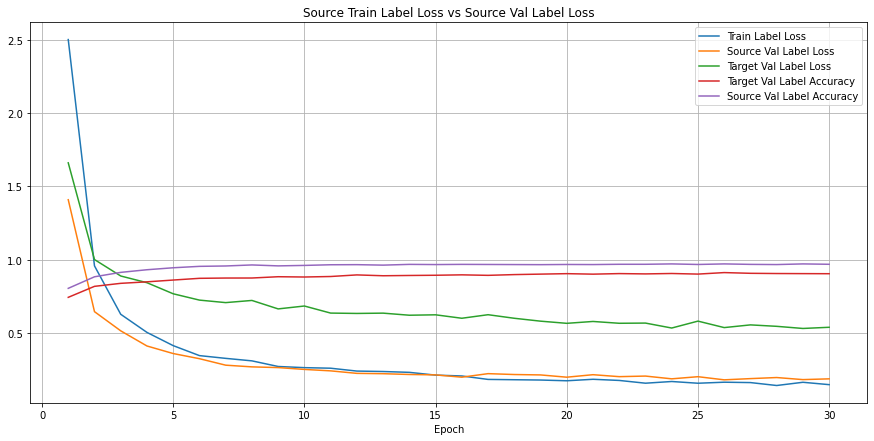

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

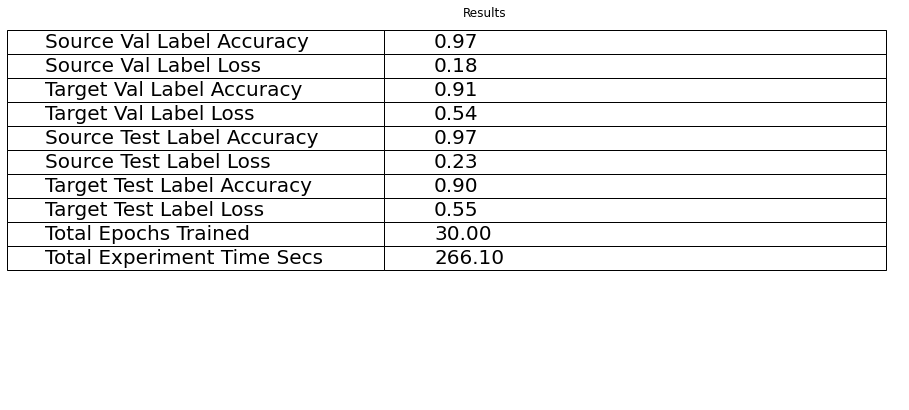

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

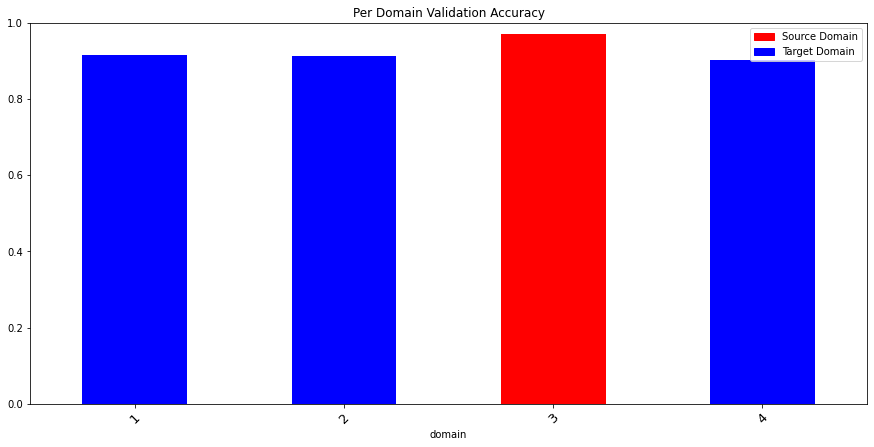

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9673076923076923 Target Test Label Accuracy: 0.9042735042735043
Source Val Label Accuracy: 0.9705128205128205 Target Val Label Accuracy: 0.9113247863247863


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "